# Optimization problem
min_recipe CO2(recipe)
max_recipe bulk(recipe)

s.t. C2S+ C3S+ C4AF+ C3A+ gypsum = 100
     limestone + silica fume + blast furnace + fly ash + calcined clay <= 100
     wc_ratio = 0.45 (constant to get the influence of water cement ratio out
     upper and lower bounds for recipe
     bulk(recipe) > 10GPa
     
where bulk(recipe) is a NN trained on simulated data from first cement hydration and second elastic moduli computation from hydrated cement

In [1]:
import pickle
from joblib import dump, load
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from ml.opt import opt, opt_gp, opt_ismo
from tensorflow.keras.models import load_model


/tmp/ipykernel_2619361/3333811975.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-05-29 12:47:29.883129: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-29 12:47:29.919755: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-29 12:

In [2]:
#Initialize an Algorithm
from pymoo.core.problem import ElementwiseProblem

from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling
# Define a Termination Criterion
from pymoo.termination import get_termination
from pymoo.optimize import minimize




    emission_factors ={
            'C3S':0.74,
            'C2S':0.74,
            'C3A':0.74,
            'C4AF':0.74,
          'fly_ash' : 0.004,# values from Alsalaman + al
          'CSH2': 0.0082, # RER market ecoinvent
          'silica_fume' : 0.0035, # GLO market ecoinvent 
          'GGBFS' : 0.13, # ROW market ecoinvent
          'limestone': 0.0023, # CH market #0.00313,  #value from A Review of Carbon Footprint Reduction in Construction Industry, from Design to Operation  Sizirici + al
          'calcined_clay': 0.27, # ROW market #0.196, #best value from Limestone calcined clay cement as a low-carbon solution to meet expanding cement demand in emerging economies, Yudiesky + al.
               
}

In [3]:
def normalized_CO2_emission_fct(x):

    emission_factors = [0.74, 0.74, 0.74, 0.74, 0.0082, 0.0023, 0.0035, 0.13, 0.004,0.27,0]
    
    # Calculate the total CO2 emissions for each material
    
    if x.shape == (11,):    
        total_emissions = np.sum(x*emission_factors)
        total_cementitious_mass  = np.sum(x[:-1])
        total_water_mass = total_cementitious_mass * x[: -1]
    else:
        #print(x.shape)
        total_emissions = np.sum(x*emission_factors, axis = 1)
        total_cementitious_mass  = np.sum(x[:, :-1], axis=1)
        total_water_mass = total_cementitious_mass * x[:, -1]    
    # Calculate the mass of water based on the wc_ratio and the total mass of cementitious materials
    # Summing only those materials that are cementitious (cement and similar)

    


    # Total mass including water
    total_mass = total_cementitious_mass + total_water_mass
    
    # Normalize emissions by the total mass
    normalized_emissions = total_emissions / total_mass

    return normalized_emissions



In [4]:
# Load the model outside the function to avoid repeated loading
global elastic_model
elastic_model = None

def elasticity(x):
    global elastic_model
    if elastic_model is None:
        model_path = '/mnt/disk1/projects/Cement/02-Software_and_Models/Models/Output/Models/elasticity_NN_5000.h5'
        elastic_model = load_model(model_path, compile=False)
    
    if x.ndim == 1: 
        x = x.reshape(1, -1)  # Reshape to maintain consistent input shape (batch_size, features)
    
    return elastic_model.predict(x)


In [15]:
# Implement the Multiobjective Optimization Problem:
class MyProblem1(ElementwiseProblem):

    def __init__(self):
        super().__init__(n_var = 11, 
                        n_obj = 2, 
                        n_ieq_constr = 4, 
                        n_eq_constr = 0, 
                        xl = [45, 10, 0, 0, 3.9, 0, 0, 0, 0, 0, 0.44], 
                        xu = [80, 32, 14, 15, 4.1, 20, 10, 35, 35, 35,0.46])


    def _evaluate(self, x, out, *args, **kwargs):
        # Ensuring x is 2D for consistent handling in functions
        if x.ndim == 1:
            x = np.expand_dims(x, axis=0)
        
        # Calculate objectives
        f1 = normalized_CO2_emission_fct(x)  # Ensure this returns a scalar or a 1D array with consistent shape
        f2_vals = elasticity(x)  # Ensure this returns a 2D array with consistent shape
        f2 = -f2_vals[:, 0] if f2_vals.ndim > 1 else -f2_vals[0]  # Negate for maximization
        
        # Constraints
        g1 = 10 - f2_vals[:, 0] if f2_vals.ndim > 1 else 10 - f2_vals[0]  # Ensuring access to the right index
        g2 = np.sum(x[:, 5:10], axis=1) - 100  # Check indices for SCM
        g3 = np.sum(x[:, :5], axis=1) - 105
        g4 = 95 - np.sum(x[:, :5], axis=1) 
        #  h1 = np.sum(x[:, :5], axis=1) - 100  # Check indices for cement ingredients
        #h2 = x[:, -1] - 0.45  # Last column for wc_ratio
    
        # Set outputs
        out["F"] = np.column_stack([f1, f2])  # Ensure correct stacking
        out["G"] = np.column_stack([g1, g2, g3, g4])  # Ensure correct stacking
      #  out["H"] = np.column_stack([h1])#, h2])  # Ensure correct stacking





problem = MyProblem1()        

In [25]:

algorithm = NSGA2(
    pop_size=100,
    n_offsprings=10,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True
)
termination = get_termination("n_gen", 1000)

In [ ]:
res = minimize(problem,
               algorithm,
               termination,
               seed=1,
               save_history=True,
               verbose=True)

X = res.X
F = res.F


1/1 [==============================] - 0s 22ms/step
n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      100 |      1 |  0.000000E+00 |  7.1319123256 |             - |             -
1/1 [==============================] - 0s 23ms/step
     2 |      110 |      1 |  0.000000E+00 |  5.4158268028 |  0.000000E+00 |             f
1/1 [==============================] - 0s 23ms/step
     3 |      120 |      1 |  0.000000E+00 |  3.9903806912 |  0.000000E+00 |             f
1/1 [==============================] - 0s 23ms/step
     4 |      130 |      2 |  0.000000E+00 |  2.8513265721 |  1.0000000000 |         ideal
1/1 [==============================] - 0s 22ms/step
     5 |      140 |      3 |  0.000000E+00 |  2.1527049807 |  0.0369314025 |         ideal
1/1 [==============================] - 0s 22ms/step
     6 |      150 |      3 |  0.000000E+00 |  1.5654890419 |  0.000000E+00 |             f
1/1 [==============================] - 0s 22ms/step

In [92]:
NDS = pd.DataFrame(X, columns = ['C3S',
        'C2S',
        'C3A',
        'C4AF',
      'CSH2',# values from Alsalaman + al
      'limestone', # RER market ecoinvent
      'silica_fume', # GLO market ecoinvent 
      'GGBFS', # ROW market ecoinvent
      'fly_ash', # CH market #0.00313,  #value from A Review of Carbon Footprint Reduction in Construction Industry, from Design to Operation  Sizirici + al
      'calcined_clay',
    'wc_ratio'])




                   

In [93]:
#NDS.loc[100,:]=[112,40,10,17,8,0,0,0,0,0,0.45]
NDS

C3S        C2S       C3A      C4AF      CSH2  limestone  \
0   56.255605  20.901711  5.824443  8.057120  3.995373  19.990118   
1   72.806729  21.519854  6.030188  0.686560  3.914426   1.200620   
2   54.054221  20.440704  9.153544  7.508157  3.977680  19.998377   
3   72.829134  21.527339  6.030834  0.631956  3.933586  19.307449   
4   72.790711  19.925062  6.939147  1.417903  3.915958  19.659537   
..        ...        ...       ...       ...       ...        ...   
95  72.850920  19.815090  7.759610  0.134451  3.995922  19.976052   
96  72.934477  20.553413  7.206980  0.307148  3.932628  10.223613   
97  72.795015  21.503092  6.049069  0.683024  3.941220   8.370071   
98  72.936755  19.520461  5.670092  0.108941  3.982915  19.989571   
99  56.660529  21.636953  9.153544  7.484811  3.985941  19.934904   

    silica_fume      GGBFS    fly_ash  calcined_clay  wc_ratio  
0      9.885612  34.983733  34.996078       0.124323  0.459313  
1      0.375151  34.982629  33.675934       0.001352  0.440096  
2      9.981476  34.981368  34.987808       0.010712  0.458654  
3      3.209386  34.992595  34.852422       0.003674  0.440082  
4      7.371652  34.981722  34.966679       0.000234  0.440091  
..          ...        ...        ...            ...       ...  
95     9.975578  34.972461  34.999651       0.000220  0.459644  
96     1.177818  34.995785  34.996462       0.005575  0.441649  
97     0.407813  34.993617  34.985313       0.000084  0.440103  
98     9.976714  34.992856  34.990687       0.000068  0.459438  
99     9.980880  34.985790  34.996769       0.010712  0.458685  

[100 rows x 11 columns]

In [94]:
EL12 = elasticity(NDS)
EL12 = pd.DataFrame(EL12, columns = ['K','G'])
EL12['E']=9*1/(1/EL12['K'].values + 3/EL12['G'].values)
EL12['P']=(3*EL12['K'].values - 2*EL12['G'].values)/(2*(3*EL12['K'].values + EL12['G'].values))
EL12

4/4 [==============================] - 0s 1ms/step


K          G          E         P
0   50.427559  18.561268  49.598442  0.336074
1   66.723564  24.343615  65.112259  0.337358
2   51.598602  18.949120  50.647423  0.336406
3   62.830063  22.938843  61.350330  0.337259
4   61.956963  22.628551  60.517990  0.337204
..        ...        ...        ...       ...
95  59.237152  21.669220  57.942451  0.336976
96  64.544350  23.555502  63.002266  0.337315
97  65.236519  23.805326  63.671261  0.337332
98  56.707394  20.789633  55.577137  0.336655
99  54.415916  19.945673  53.322102  0.336683

[100 rows x 4 columns]

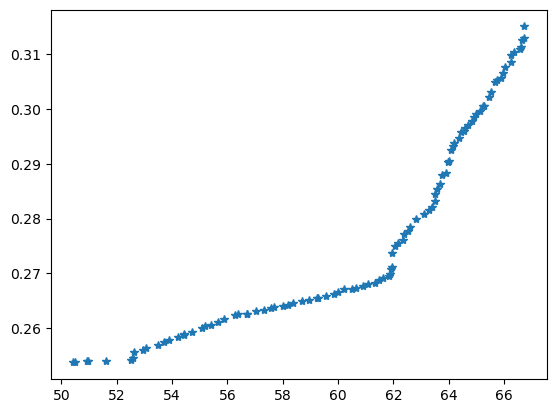

In [95]:
plt.plot(-F[:,1],F[:,0],'*')

In [96]:
new_order = [
    'C3S', 'C2S', 'C3A', 'C4AF', 'wc', 
    'RH', 'T', 'fineness', 'CSH2', 
    'limestone', 'silica_fume', 'GGBFS',
    'fly_ash', 'calcined_clay']

In [97]:
NDS['RH'] = 1
NDS['T'] = 25
NDS['fineness'] = 385
NDS['CSH2'] = 4
NDS['wc']=NDS['wc_ratio']
NDS = NDS[new_order]
NDS

C3S        C2S       C3A      C4AF        wc  RH   T  fineness  \
0   56.255605  20.901711  5.824443  8.057120  0.459313   1  25       385   
1   72.806729  21.519854  6.030188  0.686560  0.440096   1  25       385   
2   54.054221  20.440704  9.153544  7.508157  0.458654   1  25       385   
3   72.829134  21.527339  6.030834  0.631956  0.440082   1  25       385   
4   72.790711  19.925062  6.939147  1.417903  0.440091   1  25       385   
..        ...        ...       ...       ...       ...  ..  ..       ...   
95  72.850920  19.815090  7.759610  0.134451  0.459644   1  25       385   
96  72.934477  20.553413  7.206980  0.307148  0.441649   1  25       385   
97  72.795015  21.503092  6.049069  0.683024  0.440103   1  25       385   
98  72.936755  19.520461  5.670092  0.108941  0.459438   1  25       385   
99  56.660529  21.636953  9.153544  7.484811  0.458685   1  25       385   

    CSH2  limestone  silica_fume      GGBFS    fly_ash  calcined_clay  
0      4  19.990118     9.885612  34.983733  34.996078       0.124323  
1      4   1.200620     0.375151  34.982629  33.675934       0.001352  
2      4  19.998377     9.981476  34.981368  34.987808       0.010712  
3      4  19.307449     3.209386  34.992595  34.852422       0.003674  
4      4  19.659537     7.371652  34.981722  34.966679       0.000234  
..   ...        ...          ...        ...        ...            ...  
95     4  19.976052     9.975578  34.972461  34.999651       0.000220  
96     4  10.223613     1.177818  34.995785  34.996462       0.005575  
97     4   8.370071     0.407813  34.993617  34.985313       0.000084  
98     4  19.989571     9.976714  34.992856  34.990687       0.000068  
99     4  19.934904     9.980880  34.985790  34.996769       0.010712  

[100 rows x 14 columns]

In [123]:
NDS['C3S']+NDS['C2S']+NDS['C3A']+NDS['C4AF']+NDS['CSH2']

0      95.038880
1     105.043331
2      95.156626
3     105.019264
4     105.072822
         ...    
95    104.560071
96    105.002018
97    105.030200
98    102.236248
99     98.935836
Length: 100, dtype: float64

In [125]:
NDS['limestone']+NDS['silica_fume']+NDS['GGBFS']+NDS['fly_ash']+NDS['calcined_clay']

0     99.979863
1     70.235686
2     99.959741
3     92.365527
4     96.979826
        ...    
95    99.923961
96    81.399253
97    78.756897
98    99.949896
99    99.909055
Length: 100, dtype: float64

In [124]:
#Test, how accurate the model is:
from util.create_data import complete_hydration_from_data

output_materials = ["Alite", "Belite", "Aluminate", "Ferrite", "Portlandite", "C3AH6", "C4AsH12", "aq_gen",  "ettringite-AlFe", "hemihydrate", "Anhydrite","arcanite","thenardite","CSHQ", "C3AH6","monosulph-AlFe" ]

    
to_drop, train_output,pd_vol_frac = complete_hydration_from_data(NDS, output_materials, False)
pd_df = pd.DataFrame(pd_vol_frac).T
print(pd_df.keys())


Index(['aq_gen', 'gas_gen', 'HCA-Friedels-ss', 'C3(AF)S0_84H', 'CSHQ',
       'ettringite-AlFe', 'monosulph-AlFe', 'straetlingite', 'SO4_OH_AFm',
       'SO4_CO3_AFt',
       ...
       'Natrolite', 'ZeoliteX', 'ZeoliteY', 'Na-oxide', 'Sulphur', 'Quartz',
       'Silica-amorph', 'Strontianite', 'Celestite', 'Rutile'],
      dtype='object', length=110)


In [126]:
columns_to_keep = ['CSHQ', 'Belite', 'Portlandite', 'Alite', 'Aluminate', 'Ferrite', 'Portlandite', 'C3AH6', 'C4AsH12', 'aq_gen', 'OH-hydrotalcite']
other_columns = pd_df.columns.difference(columns_to_keep)
pd_df['other_material'] = pd_df[other_columns].sum(axis=1)
pd_df = pd_df[columns_to_keep + ['other_material']]
pd_df



CSHQ    Belite  Portlandite  Alite  Aluminate  Ferrite  Portlandite  \
0   0.000000  0.195823          0.0    0.0        0.0      0.0          0.0   
1   0.000000  0.235417          0.0    0.0        0.0      0.0          0.0   
2   0.000000  0.192076          0.0    0.0        0.0      0.0          0.0   
3   0.000000  0.218233          0.0    0.0        0.0      0.0          0.0   
4   0.000000  0.208259          0.0    0.0        0.0      0.0          0.0   
..       ...       ...          ...    ...        ...      ...          ...   
95  0.027383  0.187491          0.0    0.0        0.0      0.0          0.0   
96  0.000000  0.224201          0.0    0.0        0.0      0.0          0.0   
97  0.000000  0.228276          0.0    0.0        0.0      0.0          0.0   
98  0.022347  0.194892          0.0    0.0        0.0      0.0          0.0   
99  0.000000  0.189280          0.0    0.0        0.0      0.0          0.0   

       C3AH6  C4AsH12    aq_gen  OH-hydrotalcite  other_material  
0   0.177452      0.0  0.430336         0.144871        0.051518  
1   0.168491      0.0  0.425344         0.155901        0.014847  
2   0.184963      0.0  0.424663         0.145251        0.053048  
3   0.173437      0.0  0.442278         0.146767        0.019286  
4   0.173684      0.0  0.438908         0.144610        0.034539  
..       ...      ...       ...              ...             ...  
95  0.176982      0.0  0.438969         0.139937        0.029237  
96  0.176649      0.0  0.428591         0.151190        0.019369  
97  0.172702      0.0  0.428889         0.152616        0.017517  
98  0.171551      0.0  0.442427         0.140764        0.028020  
99  0.180842      0.0  0.428789         0.143393        0.057697  

[100 rows x 12 columns]

In [100]:
from prop.elastic_moduli import data_elastic_moduli
elastic_moduli = data_elastic_moduli(pd_df.transpose())
elastic_moduli

K          G          E         P
0    55.326494  19.992205  53.529048  0.338748
1    59.814338  21.760201  58.220482  0.337774
2    54.843332  19.833487  53.099510  0.338633
3    58.001381  20.972494  56.149818  0.338654
4    56.843075  20.536603  54.987714  0.338773
..         ...        ...        ...       ...
96   58.606391  21.268438  56.919852  0.338130
97   59.056514  21.444621  57.387655  0.338043
98   55.268735  19.917689  53.344935  0.339135
99   54.516951  19.692341  52.728274  0.338802
100  18.934932   8.107512  21.284665  0.312651

[101 rows x 4 columns]

In [107]:
elastic_moduli.iloc[:-1,:]

K          G          E         P
0   55.326494  19.992205  53.529048  0.338748
1   59.814338  21.760201  58.220482  0.337774
2   54.843332  19.833487  53.099510  0.338633
3   58.001381  20.972494  56.149818  0.338654
4   56.843075  20.536603  54.987714  0.338773
..        ...        ...        ...       ...
95  54.340920  19.581663  52.445446  0.339147
96  58.606391  21.268438  56.919852  0.338130
97  59.056514  21.444621  57.387655  0.338043
98  55.268735  19.917689  53.344935  0.339135
99  54.516951  19.692341  52.728274  0.338802

[100 rows x 4 columns]

In [102]:
EL12 = pd.DataFrame(EL12, columns = elastic_moduli.keys())
EL12

K          G          E         P
0   50.427559  18.561268  49.598442  0.336074
1   66.723564  24.343615  65.112259  0.337358
2   51.598602  18.949120  50.647423  0.336406
3   62.830063  22.938843  61.350330  0.337259
4   61.956963  22.628551  60.517990  0.337204
..        ...        ...        ...       ...
95  59.237152  21.669220  57.942451  0.336976
96  64.544350  23.555502  63.002266  0.337315
97  65.236519  23.805326  63.671261  0.337332
98  56.707394  20.789633  55.577137  0.336655
99  54.415916  19.945673  53.322102  0.336683

[100 rows x 4 columns]

In [111]:
(np.abs((elastic_moduli.iloc[:-1,:] -EL12))/elastic_moduli.iloc[:-1,:]).sort_values('K')

K         G         E         P
93  0.001511  0.013202  0.011600  0.006247
99  0.001853  0.012865  0.011262  0.006252
7   0.002593  0.017337  0.015732  0.006234
91  0.006387  0.024200  0.022260  0.007480
21  0.007295  0.007338  0.005745  0.006251
..       ...       ...       ...       ...
64  0.115308  0.118674  0.118309  0.001292
1   0.115511  0.118722  0.118374  0.001232
28  0.115980  0.119253  0.118898  0.001255
81  0.116503  0.120165  0.119768  0.001404
71  0.116778  0.120363  0.119974  0.001373

[100 rows x 4 columns]

In [114]:
EL12.loc[71]

K    66.613403
G    24.300785
E    64.998474
P     0.337374
Name: 71, dtype: float32

In [115]:
elastic_moduli.loc[71]

K    59.647830
G    21.690106
E    58.035693
P     0.337838
Name: 71, dtype: float64

In [116]:
NDS.loc[71]

C3S               72.799948
C2S               21.607733
C3A                5.960813
C4AF               0.681848
wc                 0.440189
RH                 1.000000
T                 25.000000
fineness         385.000000
CSH2               4.000000
limestone          2.261696
silica_fume        0.111724
GGBFS             34.993222
fly_ash           34.994159
calcined_clay      0.106321
Name: 71, dtype: float64